In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
def house_loading_data():
    # Here we are defining a path to the dataset tarball and checking if it exists.
    tarball_path = Path("datasets/house_prices.tgz")

    if not tarball_path.exists():
        # If the tarball does not exist, we download it and extract the contents.
        # parents=True allows creation of parent directories if they do not exist.
        # exist_ok=True does not raise an error if the directory already exists.
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        # Download the tarball from the URL and save it to tarball_path
        urllib.request.urlretrieve(url, tarball_path)

        # Open the tarball and extract its contents to the datasets directory
        with tarfile.open(tarball_path) as housing_tarball:
            # Extract all files from the tarball to the specified path
            housing_tarball.extractall(path="datasets")
    
    # After ensuring the dataset is available, we load it into a pandas DataFrame.
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = house_loading_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


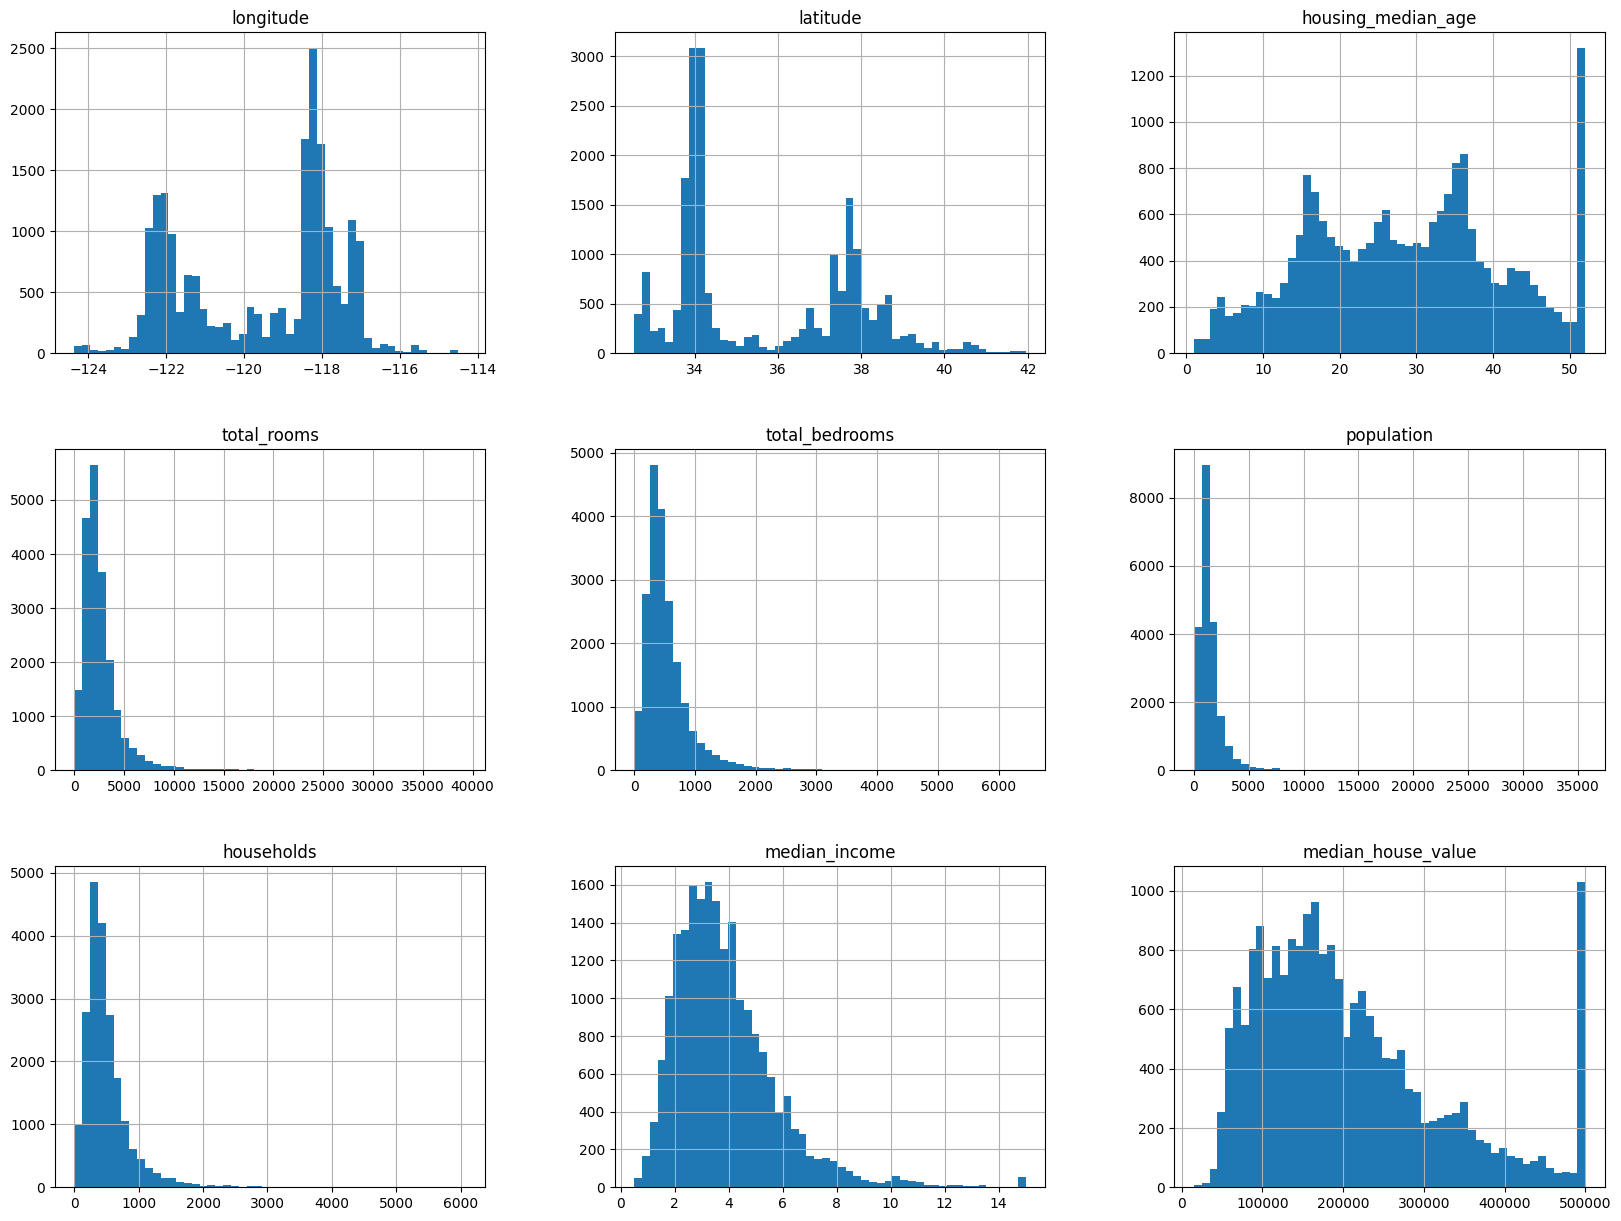

In [7]:
import matplotlib.pyplot as plt

# You can call the hist method on the whole DataFrame to plot histograms for all numeric columns.
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    # np.random.permutation generates a random permutation of the indices.
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    # data.iloc[] is used to select rows by index.
    # It returns the training and testing sets as DataFrames.
    # .iloc works with integer, array or boolean indexing.
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 16512, Test set size: 4128


In [ ]:
from zlib import crc32

# Using hash funtion does not change even if the kernel is restarted.
# This is useful for ensuring that the same data is split into training and testing sets consistently.
def is_id_in_test_set(identifier, test_ratio):
    # This function checks if an identifier is in the test set based on a hash.
    # crc32 gives outputs between 0 and 2**32.
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    # This function splits the data into training and testing sets based on a specific ID column.
    # ids here is not an numpy array, but a pandas Series.
    ids = data[id_column]
    # ids.apply helps us to apply a function to any command line
    in_test_set = ids.apply(lambda id: is_id_in_test_set(id, test_ratio))

    # We use .loc for pandas series and use .iloc for arrays.
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
# .reset_index() is used to reset/add the index of the DataFrame.
# This is useful when you want to create a new column for IDs based on the current index
housing_with_id = housing.reset_index()

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
# Usinf the index column as an ID is not a good idea, because it can change if the DataFrame is modified.
# Instead, we can create a unique ID based on the longitude and latitude, which are unlikely to change.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] 

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               # bins is grouping the median income into categories.
                               # Suppose first category is from 0 to 1.5, second category from 1.5 to 3.0, etc.
                               bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               # Labels is used to label the categories.
                               labels=[1, 2, 3, 4, 5])

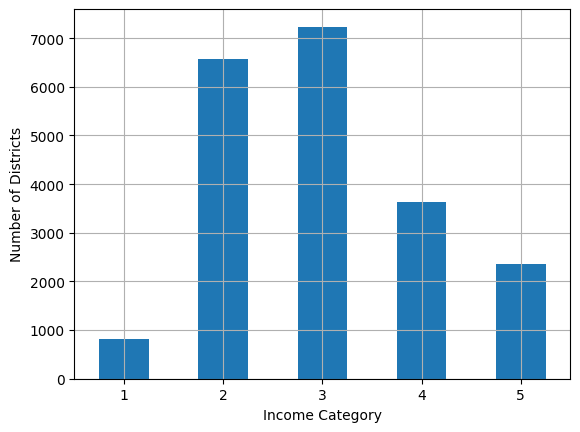

In [15]:
# sort_index() is used to sort the index of the Series. (like asceding order)
# rot=0 means that the x-axis labels will not be rotated i.e are displayed horizontally.
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
# plt.bar(housing["income_cat"].value_counts().sort_index().index,
        # housing["income_cat"].value_counts().sort_index().values)
        
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit is used to split the data into training and testing sets while preserving the distribution of a specific category.
# n_splits=10 means 10 different splits will be generated.
splitter = StratifiedShuffleSplit(n_splits = 10, test_size=0.2, random_state=42)
strat_splits = []

# The splitter.split() method generates indices for training and testing sets.
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

In [17]:
# Using the train_test_split function from sklearn to achieve the same result.
# Only gives one split, not multiple like StratifiedShuffleSplit.
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, 
                                           stratify=housing["income_cat"])

In [18]:
# first iters strat_train_set' set and on completion it moves on to strat_test_set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    # This removes the "income_cat" column from the DataFrame.
    # axis=1 means we are dropping a column, not a row.
    # inplace=True means we modify the DataFrame in place, without creating a new one.

In [ ]:
housing = strat_train_set.copy()

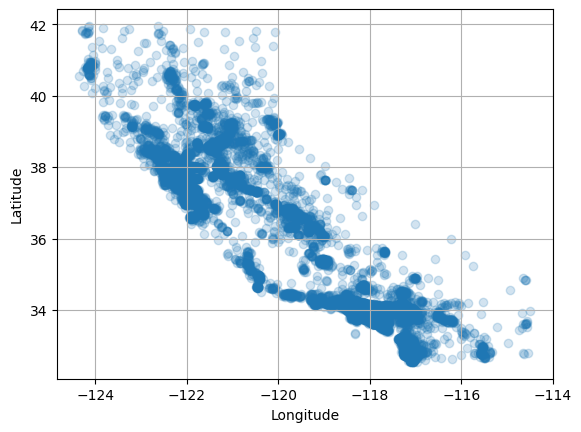

In [20]:
# alpha is used to set the transparency of the points in the scatter plot.
plt.scatter(housing["longitude"], housing["latitude"], alpha=0.2)
plt.grid(True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# This graph also looks like California i.e. the area where the dataset is focused

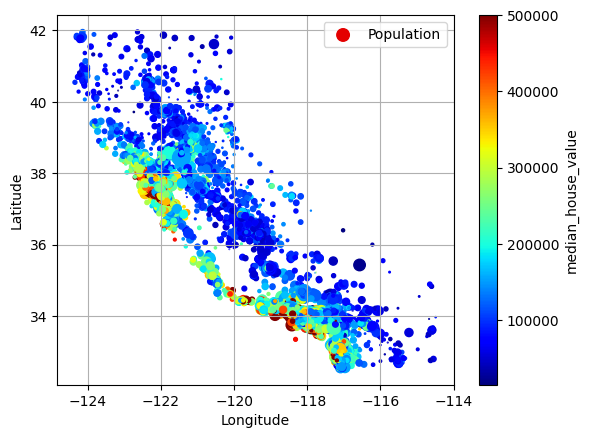

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             # s means that the size of the point represents the population.
             s = housing["population"]/100,  label="Population",
             # c means that the color of the point represents the median house value.
             c = "median_house_value", cmap=plt.get_cmap("jet"),
             # shared=True means that the x-axis is shared between the subplots i.e. same scale and ticks
             colorbar=True, legend=True, sharex=False)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [22]:
dropped_housing = housing.drop("ocean_proximity", axis=1)
# This drops the "ocean_proximity" column from the DataFrame. as this matrix does not work with strings.
corr_matrix = dropped_housing.corr()

In [23]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

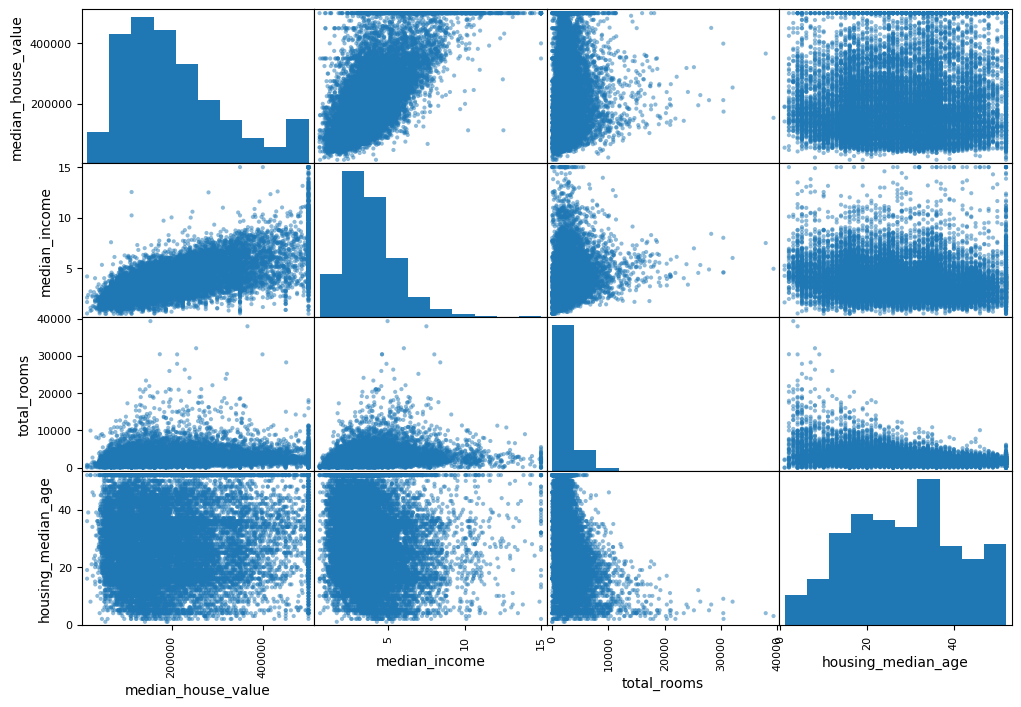

In [24]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), grid=True)
plt.show()

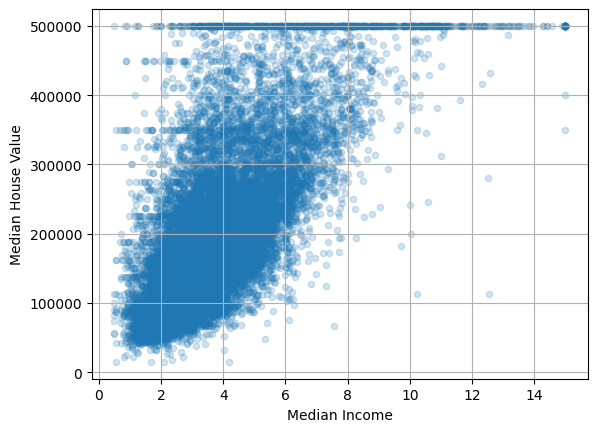

In [25]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.2)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.show()

In [26]:
dropped_housing["rooms_per_house"] = dropped_housing["total_rooms"] / dropped_housing["households"] 
dropped_housing["bedrooms_ratio"] = dropped_housing["total_bedrooms"] / dropped_housing["total_rooms"] 
dropped_housing["people_per_house"] = dropped_housing["population"] / dropped_housing["households"]

In [27]:
corr_matrix = dropped_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# Select only the numeric columns for imputation i.e. floats and integers
housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [30]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [31]:
X = imputer.transform(housing_num)

In [32]:
# X is a numpy array, so we need to convert it back to a DataFrame.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                        index=housing.index)

In [33]:
from sklearn.preprocessing import OrdinalEncoder

ordinalencoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinalencoder.fit_transform(housing_cat)

In [34]:
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [35]:
ordinalencoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
from sklearn.preprocessing import OneHotEncoder

# This is used so that the algorithm does not treat the category numbers as actual numbers.
# Suppose it may thing 4>0 etc.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [37]:
# This is a sparse matrix, so it is not displayed in full.
# It is a matrix where most of the elements are zero hence it cannot be displayed fully.
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [38]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR OCEAN"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR OCEAN
0,True,False
1,False,True


In [40]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [41]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (2, 5)>

In [42]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [43]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [44]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_minmax_scaled = minmax_scaler.fit_transform(housing_num)

In [45]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [46]:
from sklearn.metrics.pairwise import rbf_kernel

# rbf kernel is used to compute the similarity between the data points.
age_simik_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

In [47]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
# to_frame() is used to convert the Series to a DataFrame.
# This is necessary because StandardScaler expects a 2D array.
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
# [[]] is used to reshape the data to a 2D array, as LinearRegression expects the input to be 2D.
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:10]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [48]:
# TransformedTargetRegressor is used to transform the target variable before fitting the model.
# It also scales the predictions back to the original scale after making predictions.
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)

scaled_predictions = model.predict(some_new_data)

In [49]:
from sklearn.preprocessing import FunctionTransformer

# inverse_func is optional and is used to transform the data back to the original scale.
log_tranformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_tranformer.fit_transform(housing[["population"]])

In [50]:
# kw_args is used to pass additional arguments to the function.
# No inverse function for rbf_kernel
rbf_trandformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_trandformer.fit_transform(housing[["housing_median_age"]])

In [51]:
sf_coords = 37.7749, -122.41
sf_transformer =FunctionTransformer(rbf_kernel,
                                    kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.fit_transform(housing[["longitude", "latitude"]])

In [52]:
ratio_transformer = FunctionTransformer(lambda x: x[:,[0]] / x[:,[1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([[0.5 ],
       [0.75]])

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.utils.validation import check_array, check_is_fitted

class StandardClassiferClone(BaseEstimator, TransformerMixin):
    # __init_ is the constructor method that initializes the object.
    # with_mean is a parameter that determines whether to center the data by subtracting the mean.
    # self.with_mean is an instance variable that stores the value of the parameter.
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        # check_array is used to validate that the input is an array with numeric data.
        X= check_array(X)
        # store these values inside the object so later methods (like transform) can use them.
        # The _ means, this was learned from data and is not a parameter you set manually
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in = X.shape[1]
        return self
    
    def transform(self, X):
        # check_is_fitted is used to validate that the object has been fitted before calling transform.
        check_is_fitted(self)
        X = check_array(X)
        # assert is used to check that the number of features in the input matches the number of features in the training data.
        assert self.n_features_in == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
        

In [54]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        # gamma is a parameter for the RBF kernel, which controls the width of the Gaussian kernel.
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        X = check_array(X)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        # sample_weight is used to assign weights to the samples during clustering.
        # Sample weights = tell the algorithm how much each data point should influence the model’s learning
        # (higher weight = more impact, 0 = ignored).
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, input_features=None):
        # This method is used to get the feature names after transformation.
        return [f"cluster_{i}" for i in range(self.n_clusters)]

In [55]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[["longitude", "latitude"]],
                                           sample_weight = housing_labels)

In [56]:
similarities[:5].round(2)
# round() is used to round the values to 2 decimal places for better readability.
# The first row shows that the sample is closest to cluster 1 and like that
# Each column represents a cluster number

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28],
       [0.63, 0.  , 0.  , 0.52, 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  ],
       [0.87, 0.  , 0.03, 0.14, 0.  , 0.  , 0.  , 0.  , 0.89, 0.  ]])

In [57]:
from sklearn.pipeline import Pipeline

nume_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

In [58]:
from sklearn.pipeline import make_pipeline

# The same pipeline can be created using make_pipeline() function from sklearn.pipeline module.
# make_pipeline automatically names the steps based on the class names.
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

In [59]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:5].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76],
       [ 1.23, -0.88, -0.92,  0.7 ,  0.74,  0.38,  0.73, -0.85],
       [ 0.71, -0.88,  0.59,  0.79,  1.6 ,  0.44,  1.76, -0.18]])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [61]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [62]:
house_prepared = preprocessing.fit_transform(housing)

In [63]:
def column_ratio(X): 
    return X[:, [0]] / X[:, [1]]

# feature_names_out requires two inputs: the function_transformer and the feature names in.
# This is already predetermined for it so we can't change it
def ratio_name(function_transformer, feature_names_in): 
    # You cannot pass just a string, it must be a list of strings.
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        # features_names_out is calls the name_function to get the feature names after transformation.
        # Here the name is "ratio" for all the columns
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    # "one-to-one" means that the output feature names will match the input feature names one-to-one.
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

preprocessing = ColumnTransformer([ 
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]), 
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]), 
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]), 
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], # remainder means that all other columns not specified in the transformers will be passed through unchanged.
# default_num_pipeline is prebuilt pipeline that will be used for all other numeric columns.
remainder=default_num_pipeline)



In [64]:
housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared.shape)

preprocessing.get_feature_names_out()

(16512, 24)


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__cluster_0', 'geo__cluster_1',
       'geo__cluster_2', 'geo__cluster_3', 'geo__cluster_4',
       'geo__cluster_5', 'geo__cluster_6', 'geo__cluster_7',
       'geo__cluster_8', 'geo__cluster_9',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

In [65]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2)) # Round off to the nearest hundred for better readability
housing_labels.iloc[:5].values

[246000. 372700. 135700.  91400. 330900.]


array([458300., 483800., 101700.,  96100., 361800.])

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# squared=False cannot be used here as it is not supported in sklearn version 0.24.2
# So instead we use sqrt(mean_squared_error())
lin_rmse = sqrt(mean_squared_error(housing_labels, housing_predictions))
lin_rmse

68972.88910758478

In [68]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [69]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = sqrt(mean_squared_error(housing_labels, housing_predictions))
print(tree_rmse)

0.0


In [70]:
from sklearn.model_selection import cross_val_score

# negative root mean squared error is used because cross_val_score expects a score to be maximized.
# Since RMSE is a loss function, we take the negative of it to convert it into a score.
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [71]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66573.734600
std       1103.402323
min      64607.896046
25%      66204.731788
50%      66388.272499
75%      66826.257468
max      68532.210664
dtype: float64

In [72]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=10)

In [73]:
pd.Series(forest_rmse).describe()

count       10.000000
mean     47038.092799
std       1021.491757
min      45495.976649
25%      46510.418013
50%      47118.719249
75%      47480.519175
max      49140.832210
dtype: float64

In [74]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [
    # These are the parameter combinations for the RandomForestRegressor
    {'preprocessing__geo__n_clusters': [5, 8, 10], 'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [75]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [76]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
[...]
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,13.524845,1.921193,0.165942,0.029616,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43207.706201,-41708.623022,-43349.953101,-43669.848875,-43301.586291,-43047.543498,687.257364,1
13,19.830189,0.747868,0.180737,0.004712,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43870.286970,-42234.983252,-43821.344041,-43935.794558,-43789.511254,-43530.384015,649.578252,2
6,9.193935,0.338654,0.195472,0.015767,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-43841.958148,-42170.680769,-43979.441542,-44181.968225,-44059.501941,-43646.710125,746.242985,3
9,13.513899,0.790155,0.196362,0.014565,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44092.871113,-42637.900286,-44153.347458,-44374.224534,-43986.755164,-43849.019711,618.659891,4
7,13.558591,0.350638,0.200575,0.026333,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44092.871113,-42637.900286,-44153.347458,-44374.224534,-43986.755164,-43849.019711,618.659891,4


In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {"preprocessing__geo__n_clusters": randint(low=3, high=50),
                  "random_forest__max_features": randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42
)

rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....0018D63F26AA0>, 'random_forest__max_features': <scipy.stats....0018D79B29D50>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [78]:
# This finds the best estimator found during the randomized search
final_model = rnd_search.best_estimator_
# .feature_importances_ returns an array containing the feature importances.
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.02, 0.01, 0.02, 0.01, 0.  , 0.01, 0.02,
       0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.03, 0.01, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.02, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [79]:
# zip() pairs each importance score with its matching feature name
# sorted() sorts the pairs in descending order based on the importance score
# reverse=True sorts the pairs in descending order
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()), 
           reverse=True)

[(np.float64(0.18599734460509473), 'log__median_income'),
 (np.float64(0.07338850855844488), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06556941990883974), 'bedrooms__ratio'),
 (np.float64(0.05364871007672531), 'rooms_per_house__ratio'),
 (np.float64(0.04598870861894748), 'people_per_house__ratio'),
 (np.float64(0.04175269214442518), 'geo__cluster_30'),
 (np.float64(0.025976797232869678), 'geo__cluster_25'),
 (np.float64(0.023595895886342252), 'geo__cluster_36'),
 (np.float64(0.02021056221732893), 'geo__cluster_9'),
 (np.float64(0.018606917076661445), 'geo__cluster_34'),
 (np.float64(0.01813798837462886), 'geo__cluster_37'),
 (np.float64(0.017404353166326745), 'geo__cluster_18'),
 (np.float64(0.01677838614384489), 'geo__cluster_1'),
 (np.float64(0.015459009666188978), 'geo__cluster_7'),
 (np.float64(0.015325731028175922), 'geo__cluster_32'),
 (np.float64(0.015073772015038346), 'geo__cluster_13'),
 (np.float64(0.014272160962173803), 'geo__cluster_35'),
 (np.float64(0.014180636461860

In [80]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = sqrt(mean_squared_error(y_test, final_predictions))
print(final_rmse)

41445.533268606625


In [81]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
# loc is the centre point (mean) of the distribution
# scale is the standard error of the distribution
# degree of freedom is the number of data points minus the number of parameters
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39293.55594722, 43491.1590655 ])

In [82]:
import joblib

# joblib.dump() is used to save the model to a file
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [83]:
[...] # import KMeans, BaseEstimator, TransformerMixin, rbf_kernel, etc.

def column_ratio(X): [...]
def ratio_name(funcational_transformer, feature_names_in): [...]

class ClusterSimilarity(BaseEstimator, TransformerMixin): [...]

# the loaded file is just the pipeline and the trained model
final_model.reloaded = joblib.load("my_california_housing_model.pkl")

new_data = [...] # your new data
predictions = final_model.predict(new_data)

ValueError: Expected 2D array, got 1D array instead:
array=[Ellipsis].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [84]:
from sklearn.svm import SVR

svr_reg = make_pipeline(preprocessing, SVR())
param_grid = [
    # C is the regularization parameter for the error term i.e. how strict the model is for the output values
    # gamma parameter is used for rbf kernel and is completely ignored for the linear model
    {'svr__C': [0.1, 1, 10, 100, 1000],'svr__kernel': ['linear', 'rbf'], 'svr__gamma': [0.01, 0.1, 1]}
    # More combinations can be added as needed
]
grid_cv = GridSearchCV(svr_reg, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_cv.fit(housing[:5000], housing_labels[:5000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [0.1, 1, ...], 'svr__gamma': [0.01, 0.1, ...], 'svr__kernel': ['linear', 'rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [85]:
grid_cv.best_params_

{'svr__C': 1000, 'svr__gamma': 0.01, 'svr__kernel': 'linear'}

In [86]:
srv_reg = make_pipeline(preprocessing, SVR())

param_grid = [
    {'svr__C': [0.1, 1, 10, 100, 1000, ],'svr__kernel': ['linear', 'rbf'], 'svr__gamma': [0.01, 0.1, 1]}
]

rnd_cv = RandomizedSearchCV(srv_reg, param_distributions=param_grid, n_iter=10, 
                            cv=3, scoring='neg_root_mean_squared_error')
rnd_cv.fit(housing[:5000], housing_labels[:5000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"[{'svr__C': [0.1, 1, ...], 'svr__gamma': [0.01, 0.1, ...], 'svr__kernel': ['linear', 'rbf']}]"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [87]:
rnd_cv.best_params_

{'svr__kernel': 'linear', 'svr__gamma': 0.1, 'svr__C': 1000}

In [ ]:
from sklearn.feature_selection import SelectFromModel

# SelectFromModel selects features based on the importance.
# threshold parameter helps to select features based on the importance.
selected_model = SelectFromModel(RandomForestRegressor(), threshold="median")
housing_selected_set = selected_model.fit_transform(housing.drop(["ocean_proximity"], axis=1), housing_labels)

In [ ]:
# checking which columns were selected
selected_model.get_support()

array([ True,  True,  True, False, False, False, False,  True])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

class KNNRegressorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        # We do not return self in __init__
    
    def fit(self, X, y=None):
        self.knn = KNeighborsRegressor(n_neighbors=self.n_neighbors)
        self.knn.fit(X, y)
        return self
    
    # We reshape this to a 2D array because Pipeline expects a 2D array as input
    def transform(self, X):
        return self.knn.predict(X).reshape(-1, 1)
    
knn_reg = make_pipeline(preprocessing, KNNRegressorTransformer(), RandomForestRegressor())

param_grid = [
    {'knnregressortransformer__n_neighbors': [3, 5, 7, 9, 11]}
]

grid_cv = GridSearchCV(knn_reg, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_cv.fit(housing[:5000], housing_labels[:5000])

,estimator,Pipeline(step...Regressor())])
,param_grid,"[{'knnregressortransformer__n_neighbors': [3, 5, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [99]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_ = X.shape[1]
        return self
    
    def transform(self, X):
        X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        return np.array(X * self.scale_ + self.mean_)

    def feature_names_out_(self, input_features=None):
        if input_features is None:
            return np.array(input_features)
        if self.feature_names_in_ is not None:
            return self.feature_names_in_
        return np.array([f"x{i}" for i in range(self.n_features_in_)])
        

standard_scaler = StandardScalerClone()
ss_model = make_pipeline(preprocessing, StandardScalerClone(), RandomForestRegressor())

param_grid = [
    {'randomforestregressor__n_estimators': [100, 200, 300, 400, 500]}
]

grid_cv = GridSearchCV(ss_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_cv.fit(housing[:5000], housing_labels[:5000])

,estimator,Pipeline(step...Regressor())])
,param_grid,"[{'randomforestregressor__n_estimators': [100, 200, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
